# Kütüphaneleri İçe Aktarıyoruz

In [1]:
#kütüphaneler
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pathlib

import sklearn.metrics as mt
import tensorflow as tf

from PIL import Image


Kütüphanelerden sonra indirdiğimiz veri setini projemizle aynı klasörün içerisine koyuyoruz.

In [2]:
dataSet='dataSet/'

allImages = pathlib.Path(dataSet)
imageDs = len(list(allImages.glob('*/*.jpg'))) 

Daha sonra Görseller hakıında bilgi edinebilmek için bir kaç tanesinin boyutunu yazdırıyoruz

In [3]:
image=list(allImages.glob('*/*.jpg'))
if image:
    frame=image[0]
    with Image.open(frame) as img:
        width, height = img.size
        print(f"Resim: {frame}, Boyut: {width}x{height}")
        frame=image[299]
    with Image.open(frame) as img:
        width, height = img.size
        print(f"Resim: {frame}, Boyut: {width}x{height}")
        frame=image[1190]
    with Image.open(frame) as img:
        width, height = img.size
        print(f"Resim: {frame}, Boyut: {width}x{height}")

Resim: dataSet\glioma\Te-glTr_0000.jpg, Boyut: 512x512
Resim: dataSet\glioma\Te-gl_0299.jpg, Boyut: 512x512
Resim: dataSet\glioma\Tr-gl_0890.jpg, Boyut: 512x512


Kullandığımız veri setinin eğitim ve doğrulama olarak ayrılmasını ve görüntü işlme kullanacağımız model için ön hazırlığını yapıyoruz.

In [4]:

trainDs = tf.keras.utils.image_dataset_from_directory( 
    allImages, 
    validation_split=0.2, 
    subset="training", 
    seed=123, 
    image_size=(180, 180), 
    batch_size=32) 

valDs = tf.keras.utils.image_dataset_from_directory( 
    allImages, 
    validation_split=0.2, 
    subset="validation", 
    seed=123, 
    image_size=(180,180), 
    batch_size=32) 


Found 7023 files belonging to 4 classes.
Using 5619 files for training.
Found 7023 files belonging to 4 classes.
Using 1404 files for validation.


Veri Setimize ait sınıfları hazırladığımız veriler üzerinden alalım ve görüntüleyelim.

In [5]:
classes = trainDs.class_names 
print(classes)


['glioma', 'meningioma', 'notumor', 'pituitary']


Şimdi hazırladığımız veri setinden karışık olarak 30 adet görseli görselleştirelim.

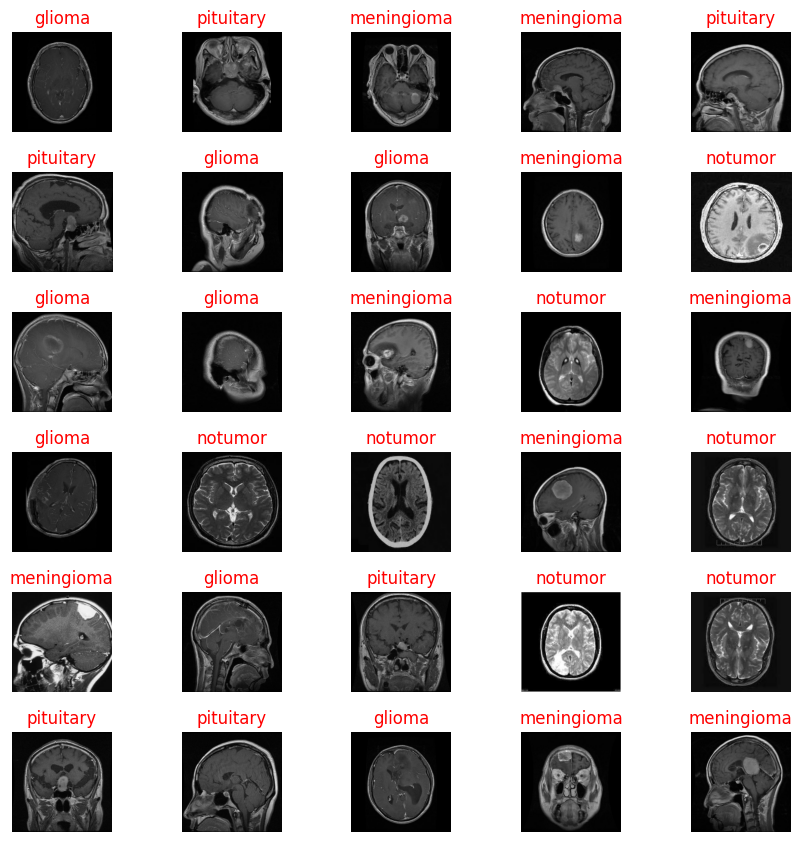

In [6]:
plt.figure(figsize=(10,10))

for images, labels in trainDs.take(1): 
    for i in range(30): 
        plt.rcParams.update({'text.color': "red",
                     'axes.labelcolor': "green"})
        ax = plt.subplot(6, 5, i + 1) 
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(classes[labels[i]]) 
        
        plt.axis("off") 

Bu aşamada iki tane model hazırladık eğitim için ilk model hızlı bir çalışma süresine sahip çünkü daha basit bir model kullanmak isterseniz ilk modeli yorum satırından çıkararak ve ikinci modeli yorum satırına alarak kullanabilirsiniz.

In [7]:
"""      
classesNum = len(classes) 

  #kendi oluşturduğumz model
MLmodel = tf.keras.Sequential([ 
    tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)), 
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'), 
    tf.keras.layers.MaxPooling2D(), 
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'), 
    tf.keras.layers.MaxPooling2D(), 
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'), 
    tf.keras.layers.MaxPooling2D(), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(classesNum) 
]) """

"      \nclassesNum = len(classes) \n\n  #kendi oluşturduğumz model\nMLmodel = tf.keras.Sequential([ \n    tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)), \n    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'), \n    tf.keras.layers.MaxPooling2D(), \n    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'), \n    tf.keras.layers.MaxPooling2D(), \n    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'), \n    tf.keras.layers.MaxPooling2D(), \n    tf.keras.layers.Flatten(), \n    tf.keras.layers.Dense(128, activation='relu'), \n    tf.keras.layers.Dense(classesNum) \n]) "

İkinci model olarak kullanılam MobileNetV3Large modeli

In [8]:
MLmodel=tf.keras.applications.MobileNetV3Large(
    input_shape=None,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
)

Modeli yazırladıktan sonra modeli derleyerek eğitime hazır hale getiriyoruz.

In [9]:
MLmodel.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy( 
                  from_logits=True), 
              metrics=['accuracy']) 
MLmodel.summary() 

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                                                                         

Modelin eğitilmesinde büyük bir rol oynayan epoch sayısını yani verinin eğitim sürecinin uzunluğunu belirtip modeli eğitime sokuyoruz.

In [10]:
epochs=10

history = MLmodel.fit( 
  trainDs, 
  validation_data=valDs, 
  epochs=epochs 
) 

Epoch 1/10


c:\Users\musta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


176/176 [==============================] - 230s 1s/step - loss: 0.3264 - accuracy: 0.9078 - val_loss: 2.6204 - val_accuracy: 0.7536
Epoch 2/10
176/176 [==============================] - 238s 1s/step - loss: 0.0846 - accuracy: 0.9690 - val_loss: 18.9655 - val_accuracy: 0.6952
Epoch 3/10
176/176 [==============================] - 227s 1s/step - loss: 0.0860 - accuracy: 0.9726 - val_loss: 29.4623 - val_accuracy: 0.6660
Epoch 4/10
176/176 [==============================] - 189s 1s/step - loss: 0.0524 - accuracy: 0.9843 - val_loss: 64.8595 - val_accuracy: 0.5043
Epoch 5/10
176/176 [==============================] - 189s 1s/step - loss: 0.0475 - accuracy: 0.9838 - val_loss: 11.7725 - val_accuracy: 0.7172
Epoch 6/10
176/176 [==============================] - 188s 1s/step - loss: 0.0188 - accuracy: 0.9945 - val_loss: 5.9920 - val_accuracy: 0.8120
Epoch 7/10
176/176 [==============================] - 188s 1s/step - loss: 0.0229 - accuracy: 0.9916 - val_loss: 1.6108 - val_accuracy: 0.8675
Epoch 

Eğitim tamalandıktan sonra eğitim sürecinde ve sonunda model eğitim peformansını değerlendirmemizi sağlayan parametre ve grafikleri görüntülüyoruz.

Model eğitim grafiği

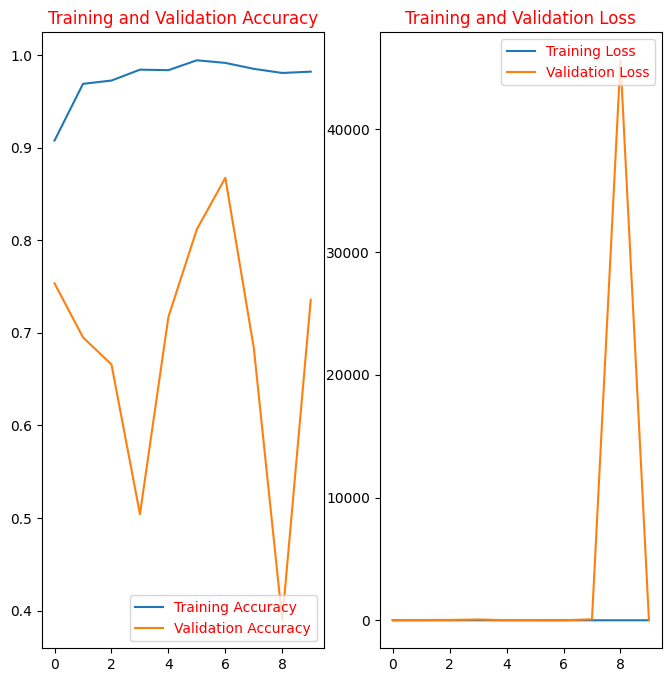

In [11]:
#Accuracy 
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
  
#loss 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
  
#epochs  
epochs_range = range(epochs) 
  
# eğitim sonucu grafikleri
plt.figure(figsize=(8, 8)) 
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training Accuracy') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 
  

plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss') 
plt.plot(epochs_range, val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show() 

Eğitim sonrası tahminler ve doğrulamalarını gösteren Confusion Matrix ve doğruluk değerlerinin hesaplanması ve görselleştirilmesi

44/44 [==============================] - 11s 223ms/step
F1 Score: 0.2462500842001969
Recall: 0.26424501424501423


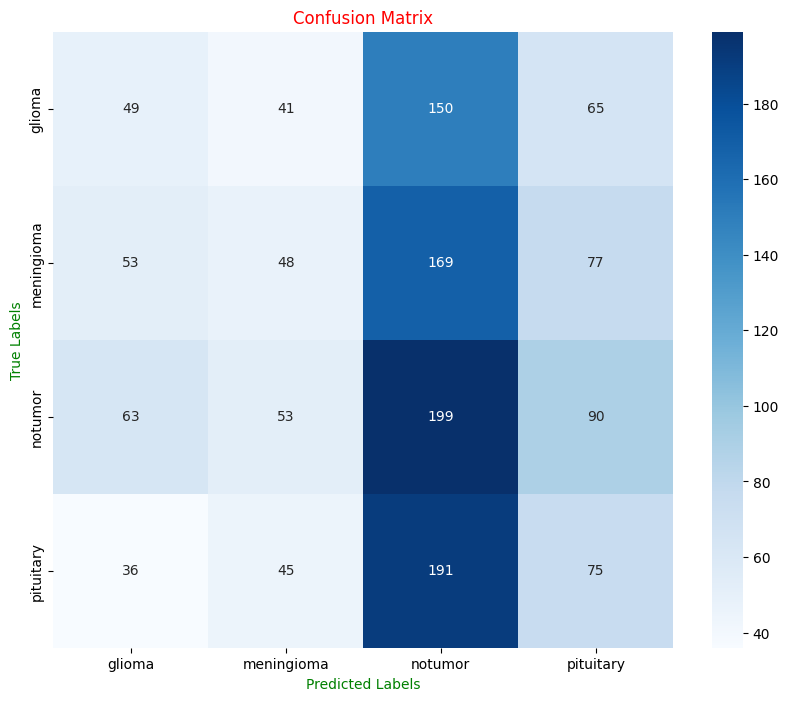

In [12]:

# Tahminler
y_pred_probs = MLmodel.predict(valDs)
y_pred = np.argmax(y_pred_probs, axis=1)

# Gerçek etiketler
y_true = np.concatenate([y for x, y in valDs], axis=0)

# Karışıklık matrisini hesaplama
conf_matrix = mt.confusion_matrix(y_true, y_pred)

# F1 skoru ve geri çağırma değerlerini hesapla
f1 = mt.f1_score(y_true, y_pred, average='weighted')
recall = mt.recall_score(y_true, y_pred, average='weighted')

# Sonuçları yazdırma
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()